In [1]:
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import geopandas as gpd
import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

np.random.seed(420)

## Laoding dataset to perform EDA

In [2]:
df_geo_info = pd.read_parquet("C:/Users/Asus/Box/Flood Damage PredictionProject/Dataset/filtered_dataset_with_geo_info.parquet.gzip")

In [3]:
df_geo_info.head()

,reportedZipCode,countyCode,censusTract,censusBlockGroupFips,latitude,longitude,state,yearOfLoss,elevatedBuildingIndicator,elevationDifference,baseFloodElevation,ratedFloodZone,occupancyType,rateMethod,crsClassificationCode,elevationCertificateIndicator,lowestFloorElevation,lowestAdjacentGrade,totalBuildingInsuranceCoverage,totalContentsInsuranceCoverage,primaryResidenceIndicator,buildingPropertyValue,causeOfDamage,contentsPropertyValue,disasterAssistanceCoverageRequired,floodCharacteristicsIndicator,floodproofedIndicator,buildingReplacementCost,contentsReplacementCost,waterDepth,floodZoneCurrent,rentalPropertyIndicator,postFIRMConstructionIndicator,buildingrelativeDamage,AgeofBuildinguntilflood,AgeofPolicyuntilflood,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,svd_9,svd_10,svd_11,svd_12,svd_13,svd_14,svd_15,svd_16,svd_17,svd_18,svd_19,svd_20,svd_21,svd_22,svd_23,svd_24,svd_25,svd_26,svd_27,svd_28,svd_29,svd_30
0,32940,12009,12009063107,120090631073,28.3,-80.7,FL,1996,0,NaN,NaN,X,1.0,7,8.0,None,NaN,NaN,100000.0,25000.0,1,100000.0,1,0.0,0.0,NaN,0,0.0,0.0,0.0,None,0,1,0.052520,8.191650,0.164271,-0.191515,-0.277861,0.438251,-0.135808,0.257442,-0.905254,0.517394,0.198713,-1.311131,-0.560012,0.519368,0.064180,0.600630,1.447684,0.548300,1.195442,-1.206848,-1.677352,-0.290665,-0.008914,0.911473,-0.777211,-0.634360,0.905508,2.180291,-0.533245,0.392365,2.021945,-0.417581,-0.243402
1,23505,51710,51710001200,517100012001,36.9,-76.3,VA,2009,0,NaN,NaN,X,1.0,1,9.0,None,NaN,NaN,150000.0,0.0,0,37260.0,1,NaN,0.0,NaN,0,113263.0,NaN,1.0,A04,0,0,0.083494,57.366188,1.273101,-0.440167,-0.026508,-0.265916,-0.101934,-0.578929,-0.273033,-0.381519,-0.066282,-0.761965,-0.364831,-0.789079,2.972900,-1.743709,4.187647,-1.028620,0.660021,0.302219,0.764221,-1.073185,-2.093600,0.419692,3.275569,-1.975996,-1.032234,22.982420,-3.494600,-1.374440,2.460046,9.894575,-4.918725
2,32583,12113,12113010809,121130108091,30.6,-87.0,FL,2004,0,NaN,NaN,C,1.0,1,7.0,None,NaN,NaN,239300.0,45300.0,1,191440.0,1,0.0,0.0,NaN,0,239300.0,0.0,0.0,AE,0,0,0.011737,38.212183,28.440794,-0.487011,-0.178706,0.300662,-0.180206,-0.122099,-0.252817,0.428306,0.024471,-0.140899,-0.029402,-0.572798,-0.472122,0.110230,-0.315755,-0.226288,-0.048457,-0.005177,-0.584027,1.562803,-0.141775,0.261002,-0.439834,-0.024958,0.928115,-0.028791,-0.085646,0.008390,0.015467,0.285856,-0.134586
3,32507,12033,12033002300,120330023004,30.4,-87.3,FL,2004,0,4.0,7.0,AE,1.0,1,8.0,None,11.0,NaN,102500.0,44800.0,1,82000.0,1,0.0,0.0,NaN,0,102500.0,0.0,0.0,None,0,0,0.800366,56.208077,17.459274,-0.389182,-0.143250,0.341384,-0.081046,0.291763,-0.666212,1.571670,-0.164597,0.058252,0.231910,0.912889,-0.768089,0.094755,0.005752,0.353880,-1.412354,1.136864,0.353490,1.320365,-0.010683,-0.476934,-0.085460,0.244494,-0.964397,0.431071,-0.234543,-0.055565,-0.255935,0.248011,-0.083549
4,28445,37141,37141920101,371419201011,34.4,-77.6,NC,1996,0,3.0,11.0,AE,1.0,1,9.0,None,13.6,NaN,73700.0,4300.0,0,73700.0,1,NaN,0.0,NaN,0,0.0,NaN,0.0,None,0,1,0.070583,16.810404,9.180014,-0.572386,-0.142794,0.306223,0.106274,0.035533,-0.221587,0.990321,-0.207453,0.470000,0.379363,1.012849,0.526264,0.347955,-0.959901,0.987863,0.029553,0.721367,0.199539,-0.391917,0.175819,-2.181929,0.966825,-0.223965,-0.775800,-0.592636,0.068290,-0.039304,0.535170,0.338631,-0.260381


In [4]:
print(f'size of the dataset before dropping: {df_geo_info.shape[0]}')

size of the dataset before dropping: 210108


## Missing Value Analysis for geo_info svd columns only

In [5]:
print(f'Absolute numbers:\n{df_geo_info.isna().sum()}')
print(f'percentage of the total data:\n{df_geo_info.isna().sum()*100/df_geo_info.shape[0]}')

Absolute numbers:
reportedZipCode                            0
countyCode                                 0
censusTract                                0
censusBlockGroupFips                       0
latitude                                   0
longitude                                  0
state                                      0
yearOfLoss                                 0
elevatedBuildingIndicator                  0
elevationDifference                   135088
baseFloodElevation                    135423
ratedFloodZone                            26
occupancyType                              0
rateMethod                                15
crsClassificationCode                  70289
elevationCertificateIndicator         172572
lowestFloorElevation                  134986
lowestAdjacentGrade                   140923
totalBuildingInsuranceCoverage            15
totalContentsInsuranceCoverage            16
primaryResidenceIndicator                  0
buildingPropertyValue                

In [6]:
# Since we are trying to evaluate geo_info columns, hence dropping the rows with NaN values 3.1% of the dataset  
# (all these are coastal locations, will resolve it by insteresting the geographic unit with continental US shapefile)

svd_columns = [f'svd_{i}' for i in range(1, 31)]

df_geo_info.dropna(subset=svd_columns, inplace=True)

In [7]:
print(f'size of the dataseta after dropping na values: {df_geo_info.shape[0]}')

size of the dataseta after dropping na values: 203580


## Target Variable Analysis

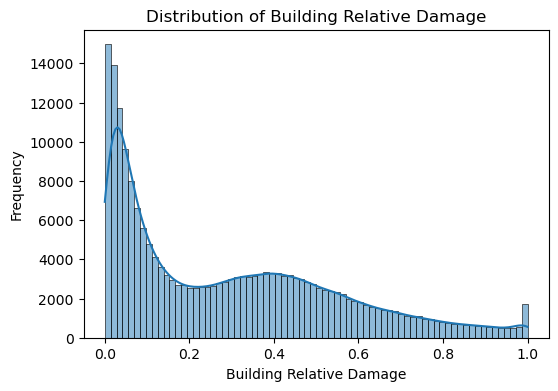


Median value of the target variable: 0.235

Mean value of the target variable: 0.290



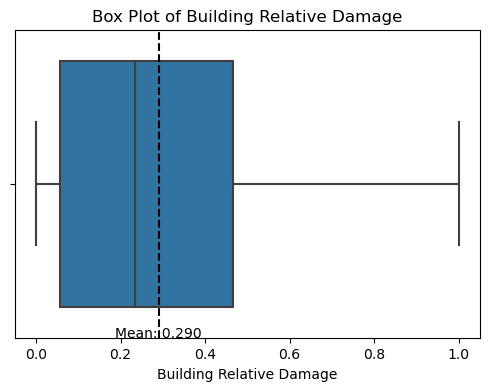

In [8]:
plt.figure(figsize=(6, 4))
sns.histplot(df_geo_info['buildingrelativeDamage'], kde=True)  # KDE=True adds a density plot
plt.title('Distribution of Building Relative Damage')
plt.xlabel('Building Relative Damage')
plt.ylabel('Frequency')
plt.show()

# Box Plot
plt.figure(figsize=(6, 4))
sns.boxplot(x=df_geo_info['buildingrelativeDamage'])
plt.title('Box Plot of Building Relative Damage')
plt.xlabel('Building Relative Damage')

# Calculate the mean and plot it
mean_value = df_geo_info['buildingrelativeDamage'].mean()
median_value = df_geo_info['buildingrelativeDamage'].median()
plt.axvline(mean_value, color='black', linestyle='--')
plt.text(mean_value, 0.5, f'Mean: {mean_value:.3f}', color = 'black', ha='center')
print(f'\nMedian value of the target variable: {median_value:.3f}')
print(f'\nMean value of the target variable: {mean_value:.3f}\n')
plt.show()

The distribution of the target variable is like a mixture model with median around 0.235

## Missing Value Analysis of FEMA columns 

In [9]:
df_geo_info.dtypes

reportedZipCode                        object
countyCode                             object
censusTract                            object
censusBlockGroupFips                   object
latitude                              float64
longitude                             float64
state                                  object
yearOfLoss                              int64
elevatedBuildingIndicator               int64
elevationDifference                   float64
baseFloodElevation                    float64
ratedFloodZone                         object
occupancyType                         float64
rateMethod                             object
crsClassificationCode                 float64
elevationCertificateIndicator          object
lowestFloorElevation                  float64
lowestAdjacentGrade                   float64
totalBuildingInsuranceCoverage        float64
totalContentsInsuranceCoverage        float64
primaryResidenceIndicator               int64
buildingPropertyValue             

In [10]:
print(f'\nAbsolute numbers:\n\n{df_geo_info.isna().sum()}')
print(f'\npercentage of the total data:\n\n{df_geo_info.isna().sum()*100/df_geo_info.shape[0]}')


Absolute numbers:

reportedZipCode                            0
countyCode                                 0
censusTract                                0
censusBlockGroupFips                       0
latitude                                   0
longitude                                  0
state                                      0
yearOfLoss                                 0
elevatedBuildingIndicator                  0
elevationDifference                   131846
baseFloodElevation                    132177
ratedFloodZone                            26
occupancyType                              0
rateMethod                                15
crsClassificationCode                  68843
elevationCertificateIndicator         167001
lowestFloorElevation                  131747
lowestAdjacentGrade                   137376
totalBuildingInsuranceCoverage            15
totalContentsInsuranceCoverage            16
primaryResidenceIndicator                  0
buildingPropertyValue              

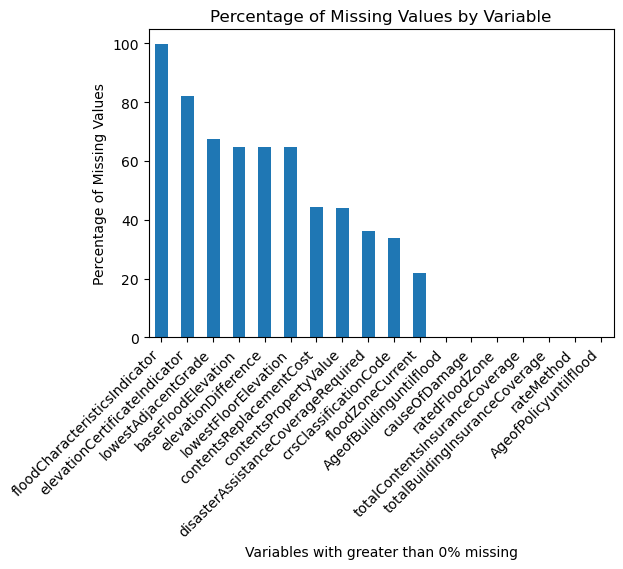

floodCharacteristicsIndicator         99.771589
elevationCertificateIndicator         82.032125
lowestAdjacentGrade                   67.480106
baseFloodElevation                    64.926319
elevationDifference                   64.763729
lowestFloorElevation                  64.715100
contentsReplacementCost               44.261715
contentsPropertyValue                 44.114844
disasterAssistanceCoverageRequired    36.209353
crsClassificationCode                 33.816190
floodZoneCurrent                      21.771785
AgeofBuildinguntilflood                0.039297
causeOfDamage                          0.031437
ratedFloodZone                         0.012771
totalContentsInsuranceCoverage         0.007859
totalBuildingInsuranceCoverage         0.007368
rateMethod                             0.007368
AgeofPolicyuntilflood                  0.000982
dtype: float64


In [11]:
missing_percent = df_geo_info.isnull().mean() * 100

missing_percent = missing_percent[missing_percent > 0]

missing_percent.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(6, 4))
missing_percent.plot.bar()
plt.title('Percentage of Missing Values by Variable')
plt.xlabel('Variables with greater than 0% missing')
plt.ylabel('Percentage of Missing Values')
plt.xticks(rotation=45, ha="right")
plt.show()

print(missing_percent)

99.77 % of floodCharacteristicsIndicator, 82.04% of elevationCertificateIndicator is missing. The percentage of missingness is too high to be imputed. We can drop these two.

For columns with > 25% missing, imputation might generate bias and uncertainity in modeling. Hence we are dropping these columns. For floodZoneCurrent we can use imputation techniques since it is correlated with ratedFloodZone. (Analysis below)

In [12]:
# List of column names to drop
columns_to_drop = [
    'floodCharacteristicsIndicator',
    'elevationCertificateIndicator',
    'lowestAdjacentGrade',
    'baseFloodElevation',
    'elevationDifference',
    'lowestFloorElevation',
    'contentsReplacementCost',
    'contentsPropertyValue',
    'disasterAssistanceCoverageRequired',
    'crsClassificationCode'
]

# Drop the columns from df_geo_info
df_geo_info.drop(columns=columns_to_drop, inplace=True)

print("Columns dropped")

Columns dropped


## floodZoneCurrent variable analysis

In [13]:
# Filter for rows where both columns 'ratedFloodZone' and 'floodZoneCurrent' are not null
not_null_subset = df_geo_info.dropna(subset=['ratedFloodZone', 'floodZoneCurrent'])

# find the percentage of these rows where the two columns match
matches = (not_null_subset['ratedFloodZone'] == not_null_subset['floodZoneCurrent']).mean() * 100

print(f"Percentage of matching 'ratedFloodZone' and 'floodZoneCurrent' (when both are not null): {matches:.2f}%")

Percentage of matching 'ratedFloodZone' and 'floodZoneCurrent' (when both are not null): 94.11%


In [14]:
# Since 94.11% are matching, we can impute missing 'floodZoneCurrent' with 'ratedFloodZone' values when 'ratedFloodZone' is not missing
df_geo_info.loc[df_geo_info['floodZoneCurrent'].isna() & df_geo_info['ratedFloodZone'].notna(), 'floodZoneCurrent'] = df_geo_info.loc[df_geo_info['floodZoneCurrent'].isna() & df_geo_info['ratedFloodZone'].notna(), 'ratedFloodZone']

print(f"Number of observations with missing floodZoneCurrent after imputation: {sum(df_geo_info['floodZoneCurrent'].isna())}")

Number of observations with missing floodZoneCurrent after imputation: 23


In [15]:
# Drop rows where 'floodZoneCurrent' is NaN
df_geo_info.dropna(subset=['floodZoneCurrent'], inplace=True)

print(f"Size of the dataset after dropping: {len(df_geo_info)}")

Size of the dataset after dropping: 203557


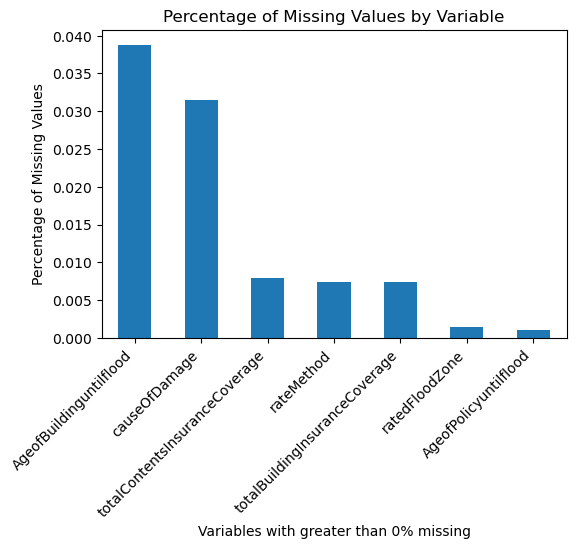

AgeofBuildinguntilflood           0.038810
causeOfDamage                     0.031441
totalContentsInsuranceCoverage    0.007860
rateMethod                        0.007369
totalBuildingInsuranceCoverage    0.007369
ratedFloodZone                    0.001474
AgeofPolicyuntilflood             0.000983
dtype: float64


In [16]:
missing_percent = df_geo_info.isnull().mean() * 100

missing_percent = missing_percent[missing_percent > 0]

missing_percent.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(6, 4))
missing_percent.plot.bar()
plt.title('Percentage of Missing Values by Variable')
plt.xlabel('Variables with greater than 0% missing')
plt.ylabel('Percentage of Missing Values')
plt.xticks(rotation=45, ha="right")
plt.show()

print(missing_percent)

In [17]:
print(f'\nAbsolute numbers:\n\n{df_geo_info.isna().sum()}')


Absolute numbers:

reportedZipCode                    0
countyCode                         0
censusTract                        0
censusBlockGroupFips               0
latitude                           0
longitude                          0
state                              0
yearOfLoss                         0
elevatedBuildingIndicator          0
ratedFloodZone                     3
occupancyType                      0
rateMethod                        15
totalBuildingInsuranceCoverage    15
totalContentsInsuranceCoverage    16
primaryResidenceIndicator          0
buildingPropertyValue              0
causeOfDamage                     64
floodproofedIndicator              0
buildingReplacementCost            0
waterDepth                         0
floodZoneCurrent                   0
rentalPropertyIndicator            0
postFIRMConstructionIndicator      0
buildingrelativeDamage             0
AgeofBuildinguntilflood           79
AgeofPolicyuntilflood              2
svd_1             

In [18]:
# since the number of observations with missing values is less that 1% and there aren't any good way to correctly impute these values, we can drop the NaN rows.

df_geo_info.dropna(inplace=True)
print(f"Size of the dataset after dropping: {len(df_geo_info)}")

Size of the dataset after dropping: 203393


Dataset of size 203,393 with high quality seems good for fractional and random forest modeling

In [19]:
# checking if any column give little to no information.

df_geo_info['floodproofedIndicator'].value_counts()

0    203391
1         2
Name: floodproofedIndicator, dtype: int64

In [20]:
# 'floodproofedIndicator' mostly is tagged as 0 indicating that the building is not floodproofed.
# another reason to why so many rows have  'floodproofedIndicator' as 0 might be that NaN values for this column are tagged as 0. 
#This in itself creates a identification problem. Dropping this column for this modeling.

columns_to_drop = [
    'floodproofedIndicator'
]

# Drop the columns from df_geo_info
df_geo_info.drop(columns=columns_to_drop, inplace=True)

print("Columns dropped")

Columns dropped


## correlation of continous variables

C:\Users\Asus\AppData\Local\Temp\ipykernel_31548\2366965973.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_geo_info.corr()


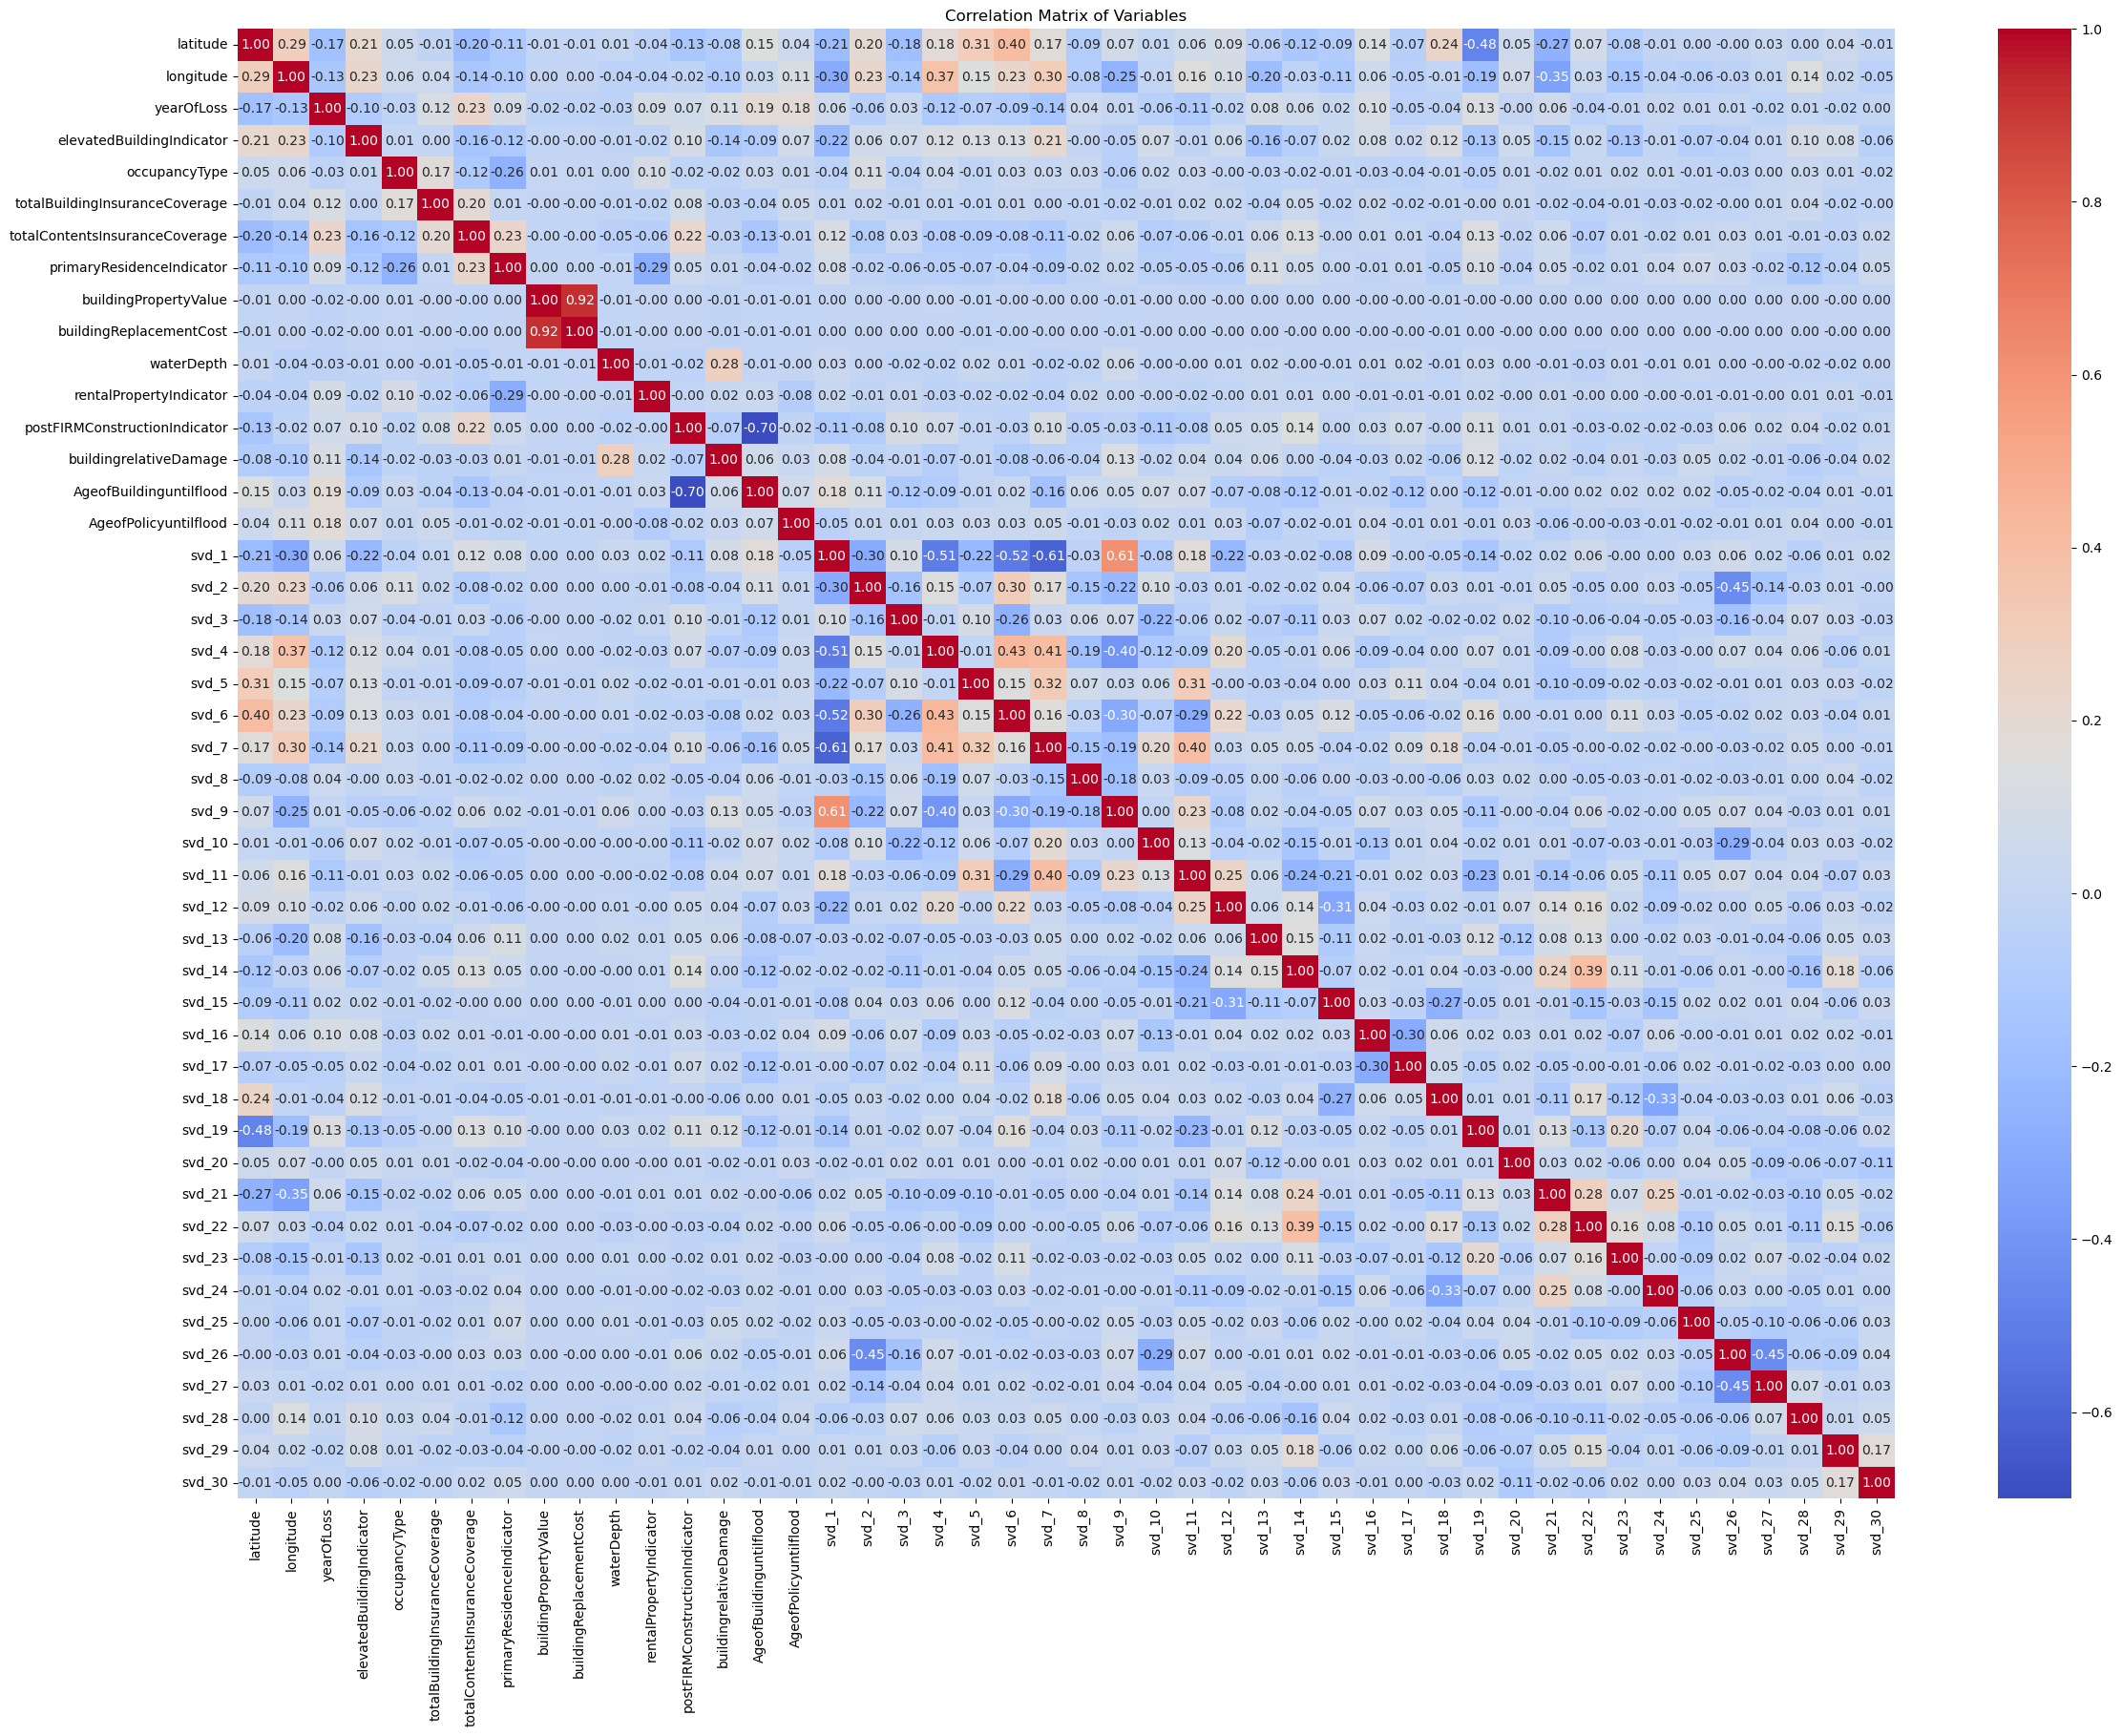

In [21]:
# Calculate the correlation matrix
correlation_matrix = df_geo_info.corr()

plt.figure(figsize=(28, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Variables')
plt.show()

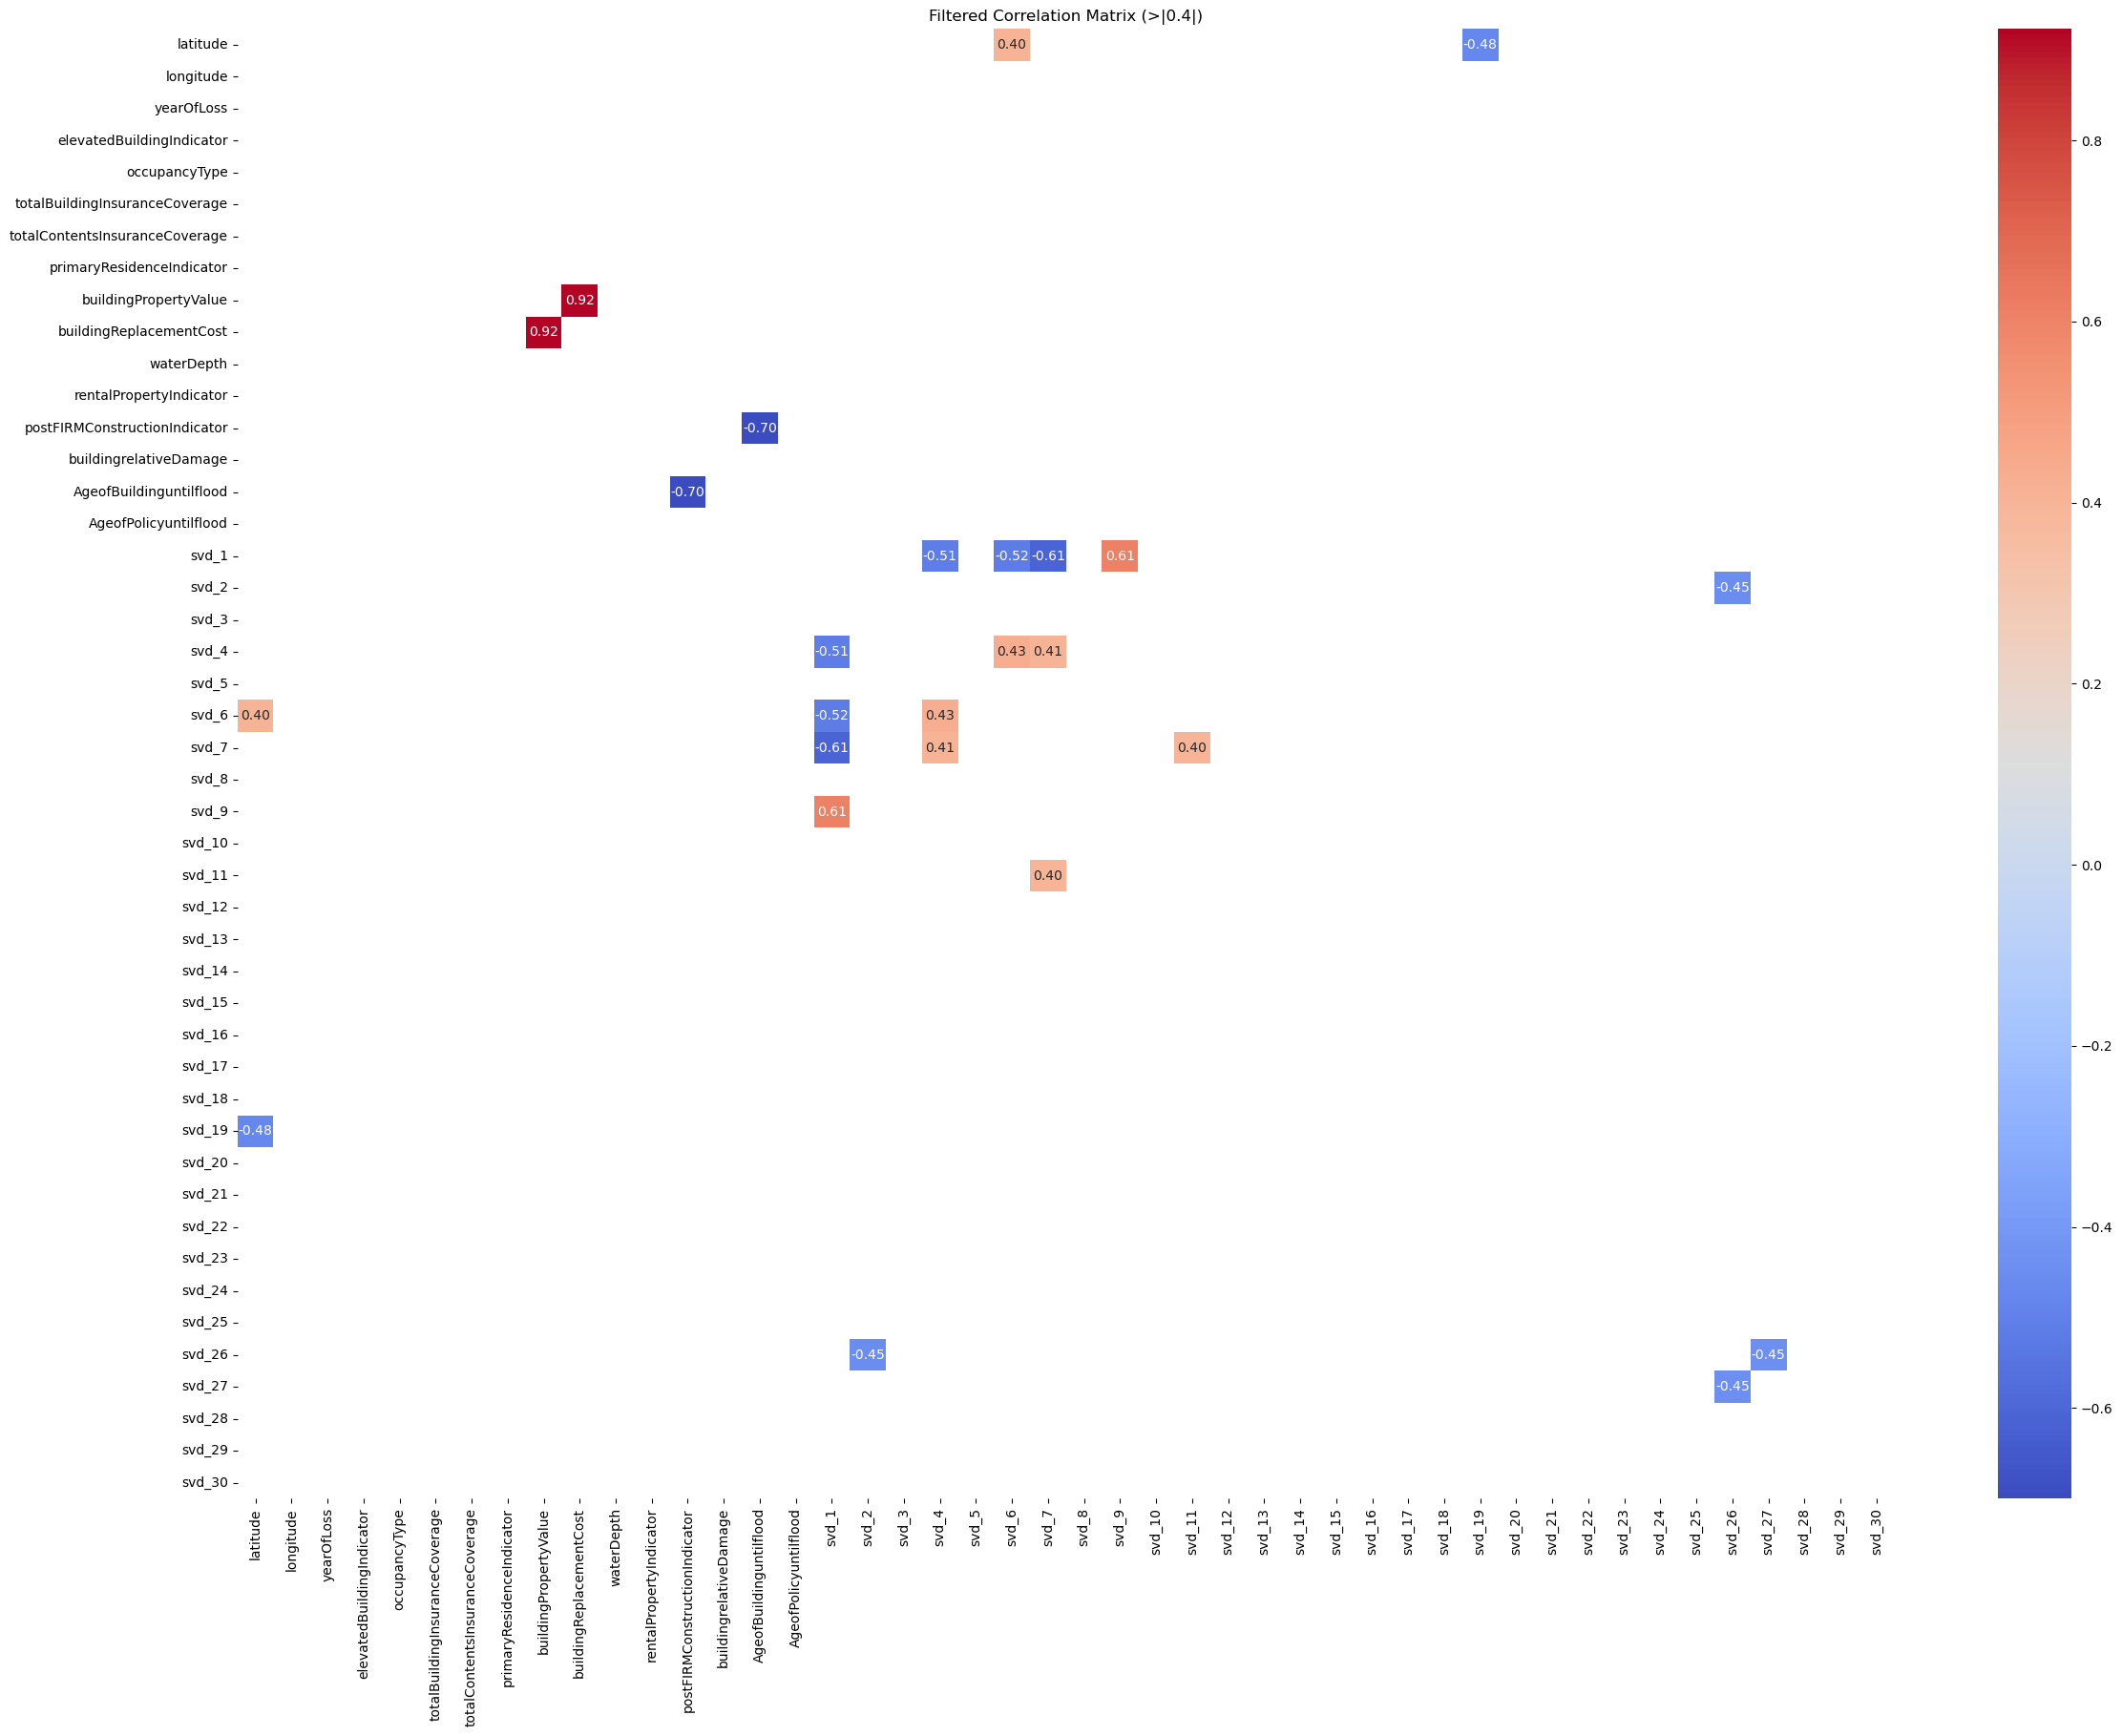

In [22]:
#showing only highly correlated columns

# Remove correlations <= 0.4 in absolute value, and set diagonal (self-correlation) to NaN
filtered_corr = correlation_matrix.where(np.abs(correlation_matrix) > 0.4)
np.fill_diagonal(filtered_corr.values, np.nan)  # Remove self-correlation

plt.figure(figsize=(28, 20))
sns.heatmap(filtered_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Filtered Correlation Matrix (>|0.4|)')
plt.show()

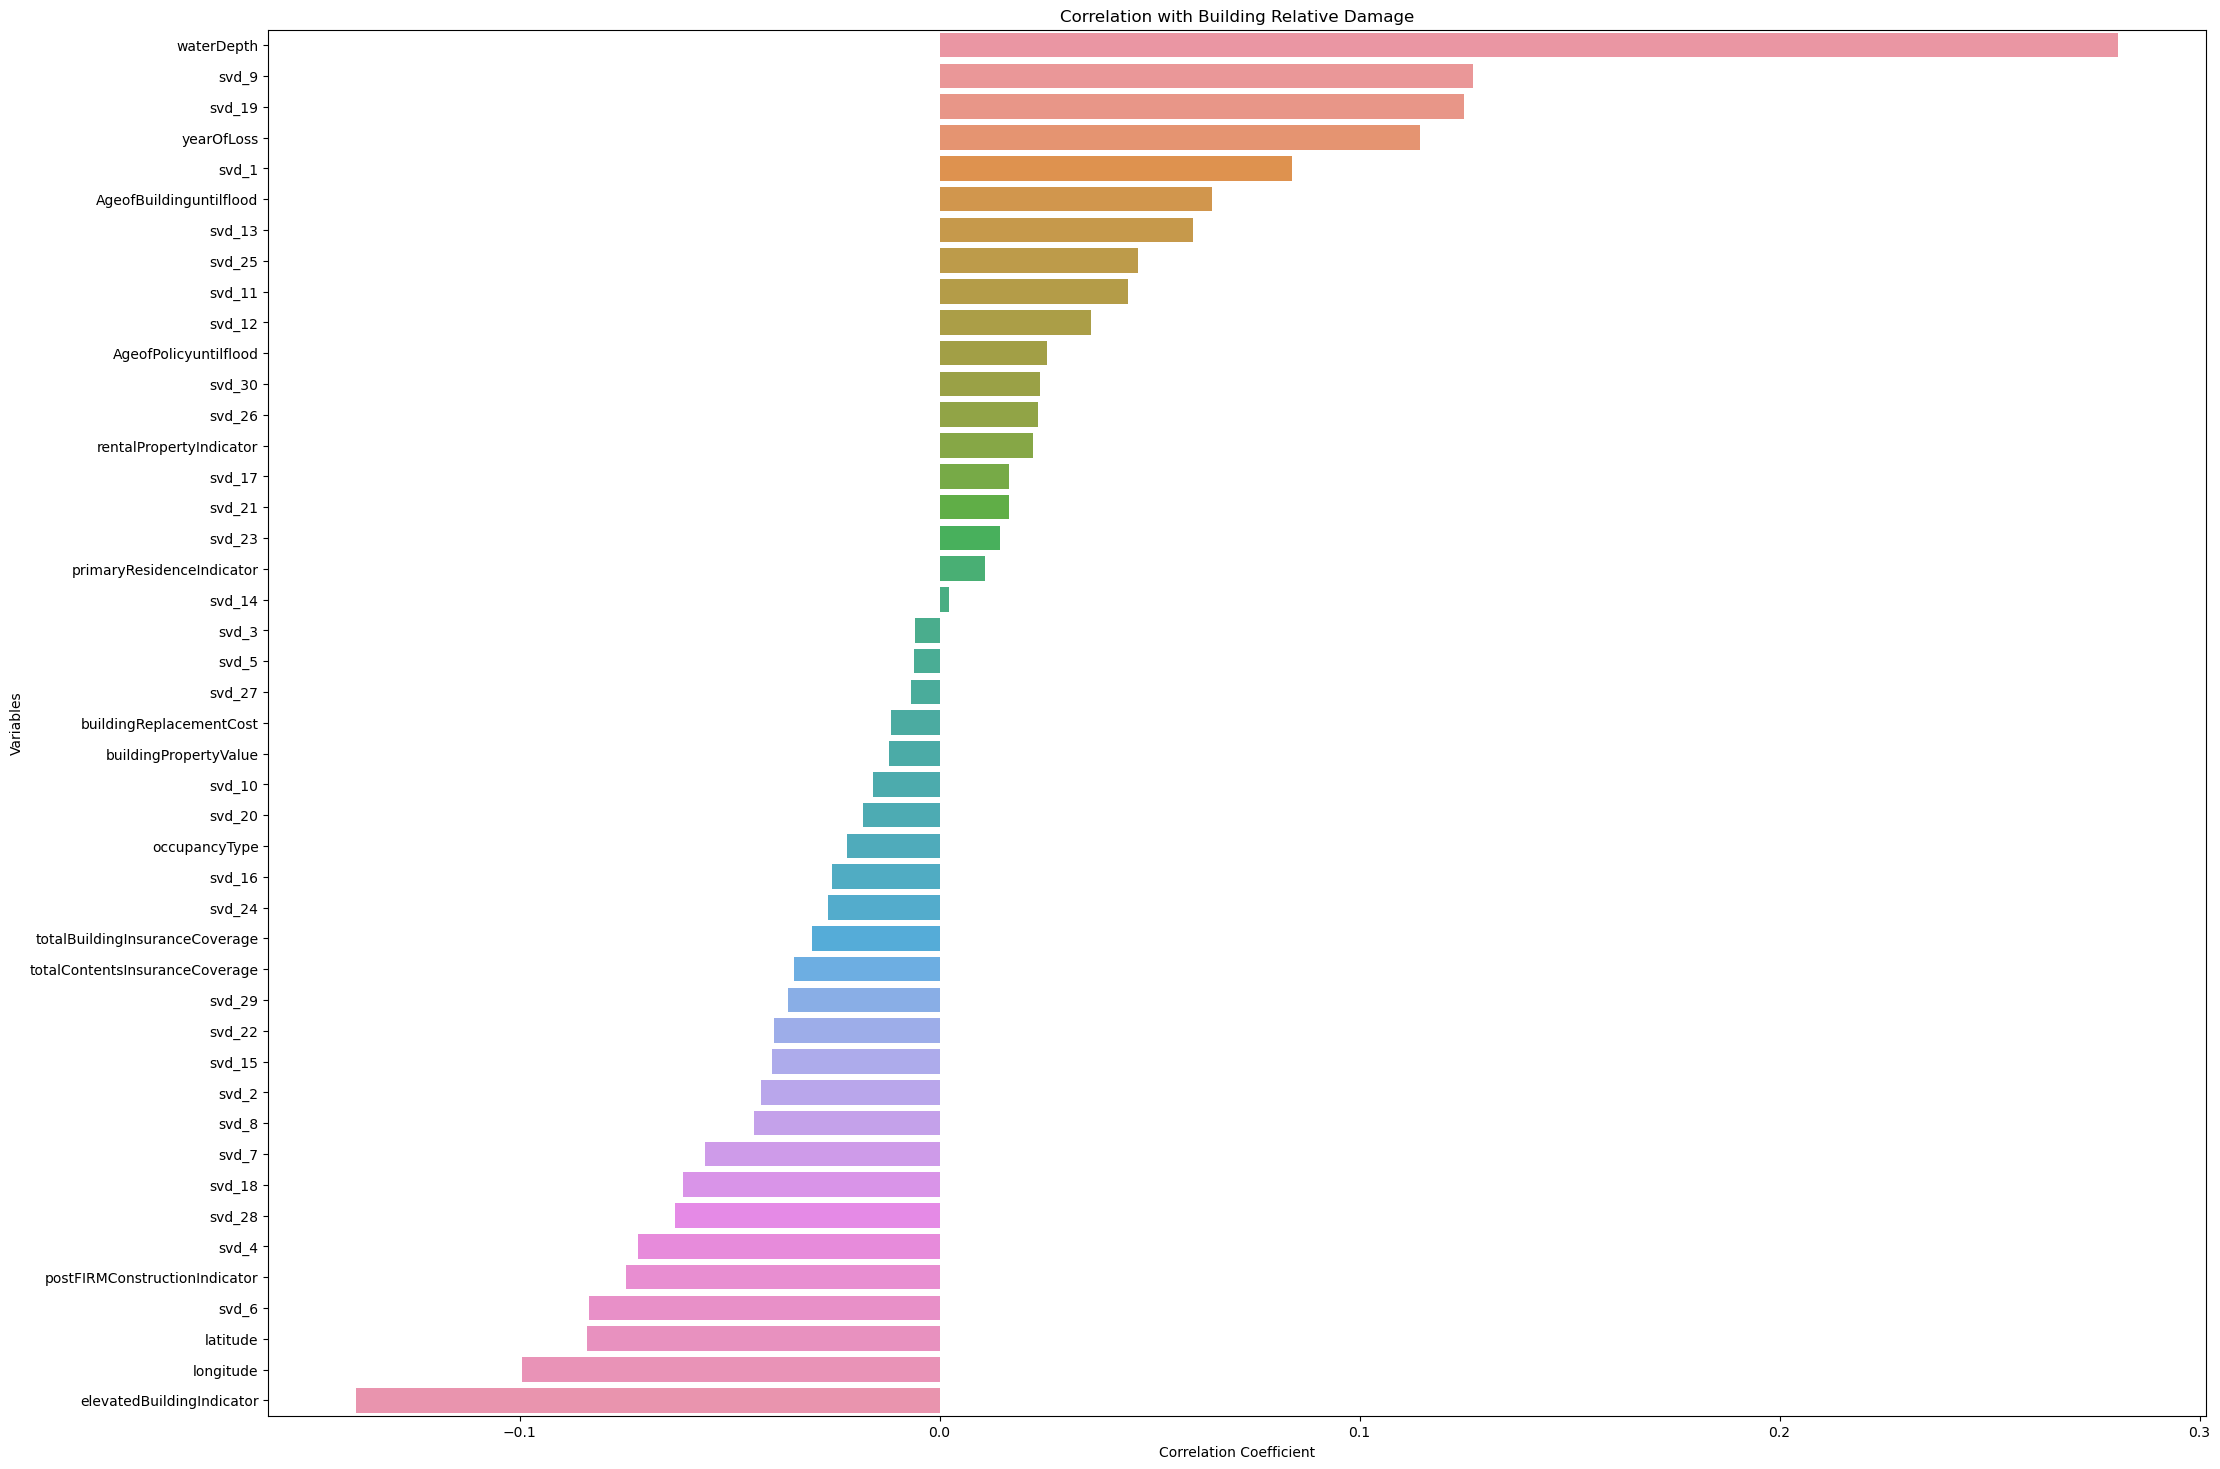

In [23]:
# correlations with the target variable 'buildingrelativeDamage'
target_correlation = correlation_matrix['buildingrelativeDamage'].drop('buildingrelativeDamage').sort_values(ascending=False)

plt.figure(figsize=(25, 18))
sns.barplot(x=target_correlation.values, y=target_correlation.index)
plt.title('Correlation with Building Relative Damage')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Variables')
plt.show()

There are a few variables that are highly correlated with other independent variables. We can use regularizied fractional regression or pca of FEMA dataset variables.

Since geo_info columns were computed using dimensionality reduction techniques, we will keep it as it is and perform cross validation.

## Preparing catergorical variables for modeling

In [24]:
df_geo_info.head()

,reportedZipCode,countyCode,censusTract,censusBlockGroupFips,latitude,longitude,state,yearOfLoss,elevatedBuildingIndicator,ratedFloodZone,occupancyType,rateMethod,totalBuildingInsuranceCoverage,totalContentsInsuranceCoverage,primaryResidenceIndicator,buildingPropertyValue,causeOfDamage,buildingReplacementCost,waterDepth,floodZoneCurrent,rentalPropertyIndicator,postFIRMConstructionIndicator,buildingrelativeDamage,AgeofBuildinguntilflood,AgeofPolicyuntilflood,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,svd_9,svd_10,svd_11,svd_12,svd_13,svd_14,svd_15,svd_16,svd_17,svd_18,svd_19,svd_20,svd_21,svd_22,svd_23,svd_24,svd_25,svd_26,svd_27,svd_28,svd_29,svd_30
0,32940,12009,12009063107,120090631073,28.3,-80.7,FL,1996,0,X,1.0,7,100000.0,25000.0,1,100000.0,1,0.0,0.0,X,0,1,0.052520,8.191650,0.164271,-0.191515,-0.277861,0.438251,-0.135808,0.257442,-0.905254,0.517394,0.198713,-1.311131,-0.560012,0.519368,0.064180,0.600630,1.447684,0.548300,1.195442,-1.206848,-1.677352,-0.290665,-0.008914,0.911473,-0.777211,-0.634360,0.905508,2.180291,-0.533245,0.392365,2.021945,-0.417581,-0.243402
1,23505,51710,51710001200,517100012001,36.9,-76.3,VA,2009,0,X,1.0,1,150000.0,0.0,0,37260.0,1,113263.0,1.0,A04,0,0,0.083494,57.366188,1.273101,-0.440167,-0.026508,-0.265916,-0.101934,-0.578929,-0.273033,-0.381519,-0.066282,-0.761965,-0.364831,-0.789079,2.972900,-1.743709,4.187647,-1.028620,0.660021,0.302219,0.764221,-1.073185,-2.093600,0.419692,3.275569,-1.975996,-1.032234,22.982420,-3.494600,-1.374440,2.460046,9.894575,-4.918725
2,32583,12113,12113010809,121130108091,30.6,-87.0,FL,2004,0,C,1.0,1,239300.0,45300.0,1,191440.0,1,239300.0,0.0,AE,0,0,0.011737,38.212183,28.440794,-0.487011,-0.178706,0.300662,-0.180206,-0.122099,-0.252817,0.428306,0.024471,-0.140899,-0.029402,-0.572798,-0.472122,0.110230,-0.315755,-0.226288,-0.048457,-0.005177,-0.584027,1.562803,-0.141775,0.261002,-0.439834,-0.024958,0.928115,-0.028791,-0.085646,0.008390,0.015467,0.285856,-0.134586
3,32507,12033,12033002300,120330023004,30.4,-87.3,FL,2004,0,AE,1.0,1,102500.0,44800.0,1,82000.0,1,102500.0,0.0,AE,0,0,0.800366,56.208077,17.459274,-0.389182,-0.143250,0.341384,-0.081046,0.291763,-0.666212,1.571670,-0.164597,0.058252,0.231910,0.912889,-0.768089,0.094755,0.005752,0.353880,-1.412354,1.136864,0.353490,1.320365,-0.010683,-0.476934,-0.085460,0.244494,-0.964397,0.431071,-0.234543,-0.055565,-0.255935,0.248011,-0.083549
4,28445,37141,37141920101,371419201011,34.4,-77.6,NC,1996,0,AE,1.0,1,73700.0,4300.0,0,73700.0,1,0.0,0.0,AE,0,1,0.070583,16.810404,9.180014,-0.572386,-0.142794,0.306223,0.106274,0.035533,-0.221587,0.990321,-0.207453,0.470000,0.379363,1.012849,0.526264,0.347955,-0.959901,0.987863,0.029553,0.721367,0.199539,-0.391917,0.175819,-2.181929,0.966825,-0.223965,-0.775800,-0.592636,0.068290,-0.039304,0.535170,0.338631,-0.260381


In [25]:
df_geo_info.dtypes

reportedZipCode                    object
countyCode                         object
censusTract                        object
censusBlockGroupFips               object
latitude                          float64
longitude                         float64
state                              object
yearOfLoss                          int64
elevatedBuildingIndicator           int64
ratedFloodZone                     object
occupancyType                     float64
rateMethod                         object
totalBuildingInsuranceCoverage    float64
totalContentsInsuranceCoverage    float64
primaryResidenceIndicator           int64
buildingPropertyValue             float64
causeOfDamage                      object
buildingReplacementCost           float64
waterDepth                        float64
floodZoneCurrent                   object
rentalPropertyIndicator             int64
postFIRMConstructionIndicator       int64
buildingrelativeDamage            float64
AgeofBuildinguntilflood           

In [26]:
print(f"Unique zipcodes: {df_geo_info['reportedZipCode'].nunique()}")
print(f"\nUnique countyCode: {df_geo_info['countyCode'].nunique()}")
print(f"\nUnique censusTract: {df_geo_info['censusTract'].nunique()}")
print(f"\nUnique censusBlockGroupFips: {df_geo_info['censusBlockGroupFips'].nunique()}")

Unique zipcodes: 9638

Unique countyCode: 2115

Unique censusTract: 17043

Unique censusBlockGroupFips: 27003


In [27]:
unique_lat_long_combinations = df_geo_info[['latitude', 'longitude']].drop_duplicates().shape[0]

print(f"Number of unique latitude-longitude combinations: {unique_lat_long_combinations}")

Number of unique latitude-longitude combinations: 9756


#### Discuss: Given there are 9756 combinations of lat-long, 2115 counties and 9638 zipcodes, binning lat-long into 4000 clusters seems fine. 

In [28]:
# from sklearn.cluster import KMeans
# 

# # Spatially bin/cluster latitude and longitude 
# n_clusters = 4000  # ( Given there are 9756 combinations of lat-long, 2115 counties and 9638 zipcodes, binning lat-long into 4000 clusters seems fine)
# kmeans = KMeans(n_clusters=n_clusters, random_state=420)
# df_geo_info['location_cluster'] = kmeans.fit_predict(df_geo_info[['latitude', 'longitude']])

In [30]:
# One-hot encode categorical variables
from sklearn.preprocessing import OneHotEncoder

# columns the require one-hot encoding 
columns_to_one_hot_encode = ['countyCode', 'state', 'ratedFloodZone', 'occupancyType', 
                             'rateMethod', 'causeOfDamage', 'floodZoneCurrent']

df_geo_info_final = pd.get_dummies(df_geo_info, columns=columns_to_one_hot_encode)

In [32]:
# geographic columns can be dropped as we are one hot encoding countyCode and state. yearOfLoss is a post event variable, hence dropping it

columns_to_drop = ['reportedZipCode', 'censusTract', 'censusBlockGroupFips', 'latitude', 'longitude']
df_geo_info_final.drop(columns=columns_to_drop, inplace = True)

In [33]:
df_geo_info_final.head()

yearOfLoss  elevatedBuildingIndicator  totalBuildingInsuranceCoverage  \
0        1996                          0                        100000.0   
1        2009                          0                        150000.0   
2        2004                          0                        239300.0   
3        2004                          0                        102500.0   
4        1996                          0                         73700.0   

   totalContentsInsuranceCoverage  primaryResidenceIndicator  \
0                         25000.0                          1   
1                             0.0                          0   
2                         45300.0                          1   
3                         44800.0                          1   
4                          4300.0                          0   

   buildingPropertyValue  buildingReplacementCost  waterDepth  \
0               100000.0                      0.0         0.0   
1                37260.0                 113263.0         1.0   
2               191440.0                 239300.0         0.0   
3                82000.0                 102500.0         0.0   
4                73700.0                      0.0         0.0   

   rentalPropertyIndicator  postFIRMConstructionIndicator  \
0                        0                              1   
1                        0                              0   
2                        0                              0   
3                        0                              0   
4                        0                              1   

   buildingrelativeDamage  AgeofBuildinguntilflood  AgeofPolicyuntilflood  \
0                0.052520                 8.191650               0.164271   
1                0.083494                57.366188               1.273101   
2                0.011737                38.212183              28.440794   
3                0.800366                56.208077              17.459274   
4                0.070583                16.810404               9.180014   

      svd_1     svd_2     svd_3     svd_4     svd_5     svd_6     svd_7  \
0 -0.191515 -0.277861  0.438251 -0.135808  0.257442 -0.905254  0.517394   
1 -0.440167 -0.026508 -0.265916 -0.101934 -0.578929 -0.273033 -0.381519   
2 -0.487011 -0.178706  0.300662 -0.180206 -0.122099 -0.252817  0.428306   
3 -0.389182 -0.143250  0.341384 -0.081046  0.291763 -0.666212  1.571670   
4 -0.572386 -0.142794  0.306223  0.106274  0.035533 -0.221587  0.990321   

      svd_8     svd_9    svd_10    svd_11    svd_12    svd_13    svd_14  \
0  0.198713 -1.311131 -0.560012  0.519368  0.064180  0.600630  1.447684   
1 -0.066282 -0.761965 -0.364831 -0.789079  2.972900 -1.743709  4.187647   
2  0.024471 -0.140899 -0.029402 -0.572798 -0.472122  0.110230 -0.315755   
3 -0.164597  0.058252  0.231910  0.912889 -0.768089  0.094755  0.005752   
4 -0.207453  0.470000  0.379363  1.012849  0.526264  0.347955 -0.959901   

     svd_15    svd_16    svd_17    svd_18    svd_19    svd_20    svd_21  \
0  0.548300  1.195442 -1.206848 -1.677352 -0.290665 -0.008914  0.911473   
1 -1.028620  0.660021  0.302219  0.764221 -1.073185 -2.093600  0.419692   
2 -0.226288 -0.048457 -0.005177 -0.584027  1.562803 -0.141775  0.261002   
3  0.353880 -1.412354  1.136864  0.353490  1.320365 -0.010683 -0.476934   
4  0.987863  0.029553  0.721367  0.199539 -0.391917  0.175819 -2.181929   

     svd_22    svd_23    svd_24     svd_25    svd_26    svd_27    svd_28  \
0 -0.777211 -0.634360  0.905508   2.180291 -0.533245  0.392365  2.021945   
1  3.275569 -1.975996 -1.032234  22.982420 -3.494600 -1.374440  2.460046   
2 -0.439834 -0.024958  0.928115  -0.028791 -0.085646  0.008390  0.015467   
3 -0.085460  0.244494 -0.964397   0.431071 -0.234543 -0.055565 -0.255935   
4  0.966825 -0.223965 -0.775800  -0.592636  0.068290 -0.039304  0.535170   

     svd_29    svd_30  countyCode_00000  countyCode_01001  countyCode_01003  \
0 -0.417581 -0.243402                 0            

In [34]:
print(f"Number of rows in the resultant dataset: {df_geo_info_final.shape[0]}\nNumber of columns in the resultant dataset: {df_geo_info_final.shape[1]}")

Number of rows in the resultant dataset: 203393
Number of columns in the resultant dataset: 2369


In [35]:
df_geo_info_final.dtypes

yearOfLoss                          int64
elevatedBuildingIndicator           int64
totalBuildingInsuranceCoverage    float64
totalContentsInsuranceCoverage    float64
primaryResidenceIndicator           int64
buildingPropertyValue             float64
buildingReplacementCost           float64
waterDepth                        float64
rentalPropertyIndicator             int64
postFIRMConstructionIndicator       int64
buildingrelativeDamage            float64
AgeofBuildinguntilflood           float64
AgeofPolicyuntilflood             float64
svd_1                             float64
svd_2                             float64
svd_3                             float64
svd_4                             float64
svd_5                             float64
svd_6                             float64
svd_7                             float64
svd_8                             float64
svd_9                             float64
svd_10                            float64
svd_11                            

In [36]:
df_geo_info_final.to_parquet(f"C:/Users/Asus/Box/Flood Damage PredictionProject/Dataset/filtered_dataset_with_geo_info_with_encoding.parquet.gzip", compression='gzip')